MAML Epoch 0 | Meta Loss: 0.6089
MAML Epoch 400 | Meta Loss: 0.2525
MAML Epoch 800 | Meta Loss: 0.1876
MAML Epoch 1200 | Meta Loss: 0.2494
MAML Epoch 1600 | Meta Loss: 0.1888
Baseline Epoch 0 Loss 0.6789604902267456
Baseline Epoch 400 Loss 0.27014223486185074
Baseline Epoch 800 Loss 0.30357318073511125
Baseline Epoch 1200 Loss 0.27343352138996124
Baseline Epoch 1600 Loss 0.3605056643486023


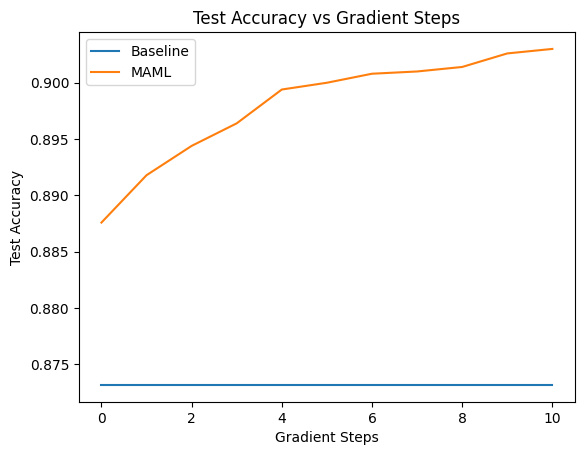

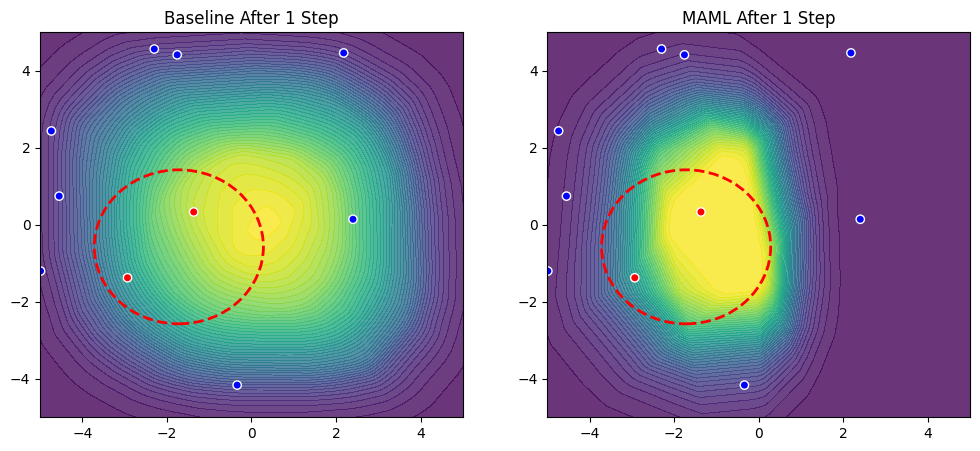

In [19]:
import torch              #Import required libraries
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset creation

def generate_circle_task(n_total=5000 , n_support=10): #function for dadaset creation
    cx, cy = np.random.uniform(-3, 3, size=2)
    r = 2.0  # Requirement: fixed radius

    X = np.random.uniform(-5, 5, size=(n_total, 2)) #Generating random 2d points
    dist = np.sqrt((X[:, 0] - cx)**2 + (X[:, 1] - cy)**2) #computing distance from circle centre
    y = (dist < r).astype(int) #If point is inside circle then consider it as 1 else 0

    indices = np.random.permutation(n_total) #Randomizing data
    supp_idx, qry_idx = indices[:n_support], indices[n_support:] #getting support and query set

    return (torch.tensor(X[supp_idx], dtype=torch.float32).to(device),         #converting them to tensor
            torch.tensor(y[supp_idx], dtype=torch.float32).unsqueeze(1).to(device),
            torch.tensor(X[qry_idx], dtype=torch.float32).to(device),
            torch.tensor(y[qry_idx], dtype=torch.float32).unsqueeze(1).to(device),
            (cx, cy, r))


#Making neural network for MAML based appraoch
class MAMLNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.weights = nn.ParameterDict({  #FOr storing weights manually
            'w1': nn.Parameter(torch.randn(2, 64) * 0.1),
            'b1': nn.Parameter(torch.zeros(64)),
            'w2': nn.Parameter(torch.randn(64, 64) * 0.1),
            'b2': nn.Parameter(torch.zeros(64)),
            'w3': nn.Parameter(torch.randn(64, 1) * 0.1),
            'b3': nn.Parameter(torch.zeros(1))
        })

    def forward(self, x, params=None):  #Defining forward function
        if params is None:
            params = self.weights

        x = F.linear(x, params['w1'].t() , params['b1'])
        x = F.relu(x)
        x = F.linear(x, params['w2'].t(), params['b2'])
        x = F.relu(x)
        x = F.linear(x, params['w3'].t(), params['b3'])
        return x



#Baseline neural network
class BaselineNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Standard neural network layers
        self.net = nn.Sequential(
            nn.Linear(2, 64),   # input (x,y) → 64 features
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)    # output probability
        )

    def forward(self, x):
        return self.net(x)



#Training maml network
def train_maml(epochs=2000, inner_lr=0.1, meta_lr=0.01):
    model = MAMLNet().to(device)
    meta_opt = optim.Adam(model.parameters(), lr=meta_lr) #optimiser to update meta parameters
    loss_fn = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        Xs, ys, Xq, yq, _ = generate_circle_task() #getting dataset

        #Inner loop
        logits = model(Xs)
        inner_loss = loss_fn(logits, ys) #calculating loss between predicted y and actual y

        # Create_graph=True is needed for maml meta gradients
        grads = torch.autograd.grad(inner_loss, model.weights.values(), create_graph=True)

        adapted_params = {} #for storing adapted parameters
        for (name, param), grad in zip(model.weights.items(), grads): #For storing model weights and their gradients in pairs
            adapted_params[name] = param - inner_lr * grad #storing adapted parameters

        #Outer loop meta update
        query_logits = model(Xq, adapted_params) #Now we are starting from adapted parameters
        meta_loss = loss_fn(query_logits, yq)

        meta_opt.zero_grad() #clearing old gradients
        meta_loss.backward()
        meta_opt.step() #Updating initial weights

        if epoch % 400 == 0:
            print(f"MAML Epoch {epoch} | Meta Loss: {meta_loss.item():.4f}") #Printing meta loss after 400 epochs
    return model

tasks_per_epoch = 1000   # number of tasks mixed per epoch for baseline


def train_baseline(epochs=2000, tasks_per_epoch = 10 ): #Training baseline model
    model = BaselineNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        total_loss = 0

        # mixing multiple tasks together
        for _ in range(tasks_per_epoch):
            Xs, ys, _, _, _ = generate_circle_task(n_total=500, n_support=50)

            optimizer.zero_grad()
            loss = loss_fn(model(Xs), ys)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if epoch % 400 == 0:
            print("Baseline Epoch", epoch, "Loss", total_loss/tasks_per_epoch)

    return model



def adapt_and_evaluate(model, steps=10, lr=0.01):
    Xs, ys, Xq, yq, _ = generate_circle_task()

    adapted = deepcopy(model) #creating copy of model
    opt = torch.optim.SGD(adapted.parameters(), lr=lr) #Creating gradient descent updater
    loss_fn = nn.BCEWithLogitsLoss()

    accs = [] #For storing accuracy values

    for step in range(steps+1):

        adapted.eval()
        #evaluating on query set
        with torch.no_grad():
            pred = torch.sigmoid(adapted(Xq)) > 0.5 #Predicted value by model
            acc = (pred.float() == yq).float().mean().item()
            accs.append(acc)

        if step < steps:
            adapted.train()
            opt.zero_grad() #clearing old gradient
            loss = loss_fn(adapted(Xs), ys) #model predicts on support set
            loss.backward()
            opt.step()

    return accs

#Function for plotting heat map
def plot_heatmaps(maml, baseline):
    Xs, ys, Xq, yq, (cx, cy, r) = generate_circle_task() #new circle classification problem

    def get_heatmap(model): #Getting heat map function
        m_copy = deepcopy(model)
        opt = optim.SGD(m_copy.parameters(), lr=0.1)
        loss_fn = nn.BCEWithLogitsLoss()

        opt.zero_grad()


        loss_fn(m_copy(Xs), ys).backward()
        opt.step()

        grid_res = 100 #Grid of 100*100 points
        x = np.linspace(-5, 5, grid_res) #creating numbers between -5 and 5
        y = np.linspace(-5, 5, grid_res)
        xx, yy = np.meshgrid(x, y) #creating coordinate pairs
        grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device) #converting them to tensor

        with torch.no_grad():
            probs = torch.sigmoid(m_copy(grid_tensor)).cpu().numpy().reshape(grid_res, grid_res) #Converting them to 2 array for plotting and calculating probability
        return xx, yy, probs

    plt.figure(figsize=(12, 5)) #creating figure
    for i, (m, title) in enumerate([(baseline, "Baseline"), (maml, "MAML")]):
        plt.subplot(1, 2, i+1)
        xx, yy, zz = get_heatmap(m)
        plt.contourf(xx, yy, zz, levels=50, cmap='viridis', alpha=0.8) #Plotting map
        circle = plt.Circle((cx, cy), r, color='red', fill=False, linestyle='--', linewidth=2)
        plt.gca().add_patch(circle)
        plt.scatter(Xs[:,0].cpu(), Xs[:,1].cpu(), c=ys.cpu().flatten(), edgecolors='w', cmap='bwr', label='Support Set')
        plt.title(f"{title} After 1 Step")
    plt.show()

maml_model = train_maml()
baseline_model = train_baseline()

maml_acc = adapt_and_evaluate(maml_model, steps=10)
baseline_acc = adapt_and_evaluate(baseline_model, steps=10)

# Plot adaptation curve
plt.figure()
plt.plot(baseline_acc, label="Baseline")
plt.plot(maml_acc, label="MAML")
plt.xlabel("Gradient Steps")
plt.ylabel("Test Accuracy")
plt.legend()
plt.title("Test Accuracy vs Gradient Steps")
plt.show()

#Plot of heat map
plot_heatmaps(maml_model, baseline_model)

Accuracy plot shows that maml based appraoch is well suitable for task adaptation problems like this in this assignment. It is visible from the graph that maml curve is above baseline and continoulsy increasing.

I did various changes but unable to understand why baseline curve is almost flat. It can be possible due to less training examples and task adaptation is not well suited in baseline.

Also heat map for maml is much better than baseline model again proving success of maml based model.